Running Euler simulation...


<IPython.core.display.Javascript object>


Running RK4 simulation...


<IPython.core.display.Javascript object>


Getting Astropy reference data...


C:\Users\colin\anaconda3\Lib\site-packages\erfa\core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
C:\Users\colin\anaconda3\Lib\site-packages\erfa\core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
C:\Users\colin\anaconda3\Lib\site-packages\erfa\core.py:133: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)



Comparing methods...


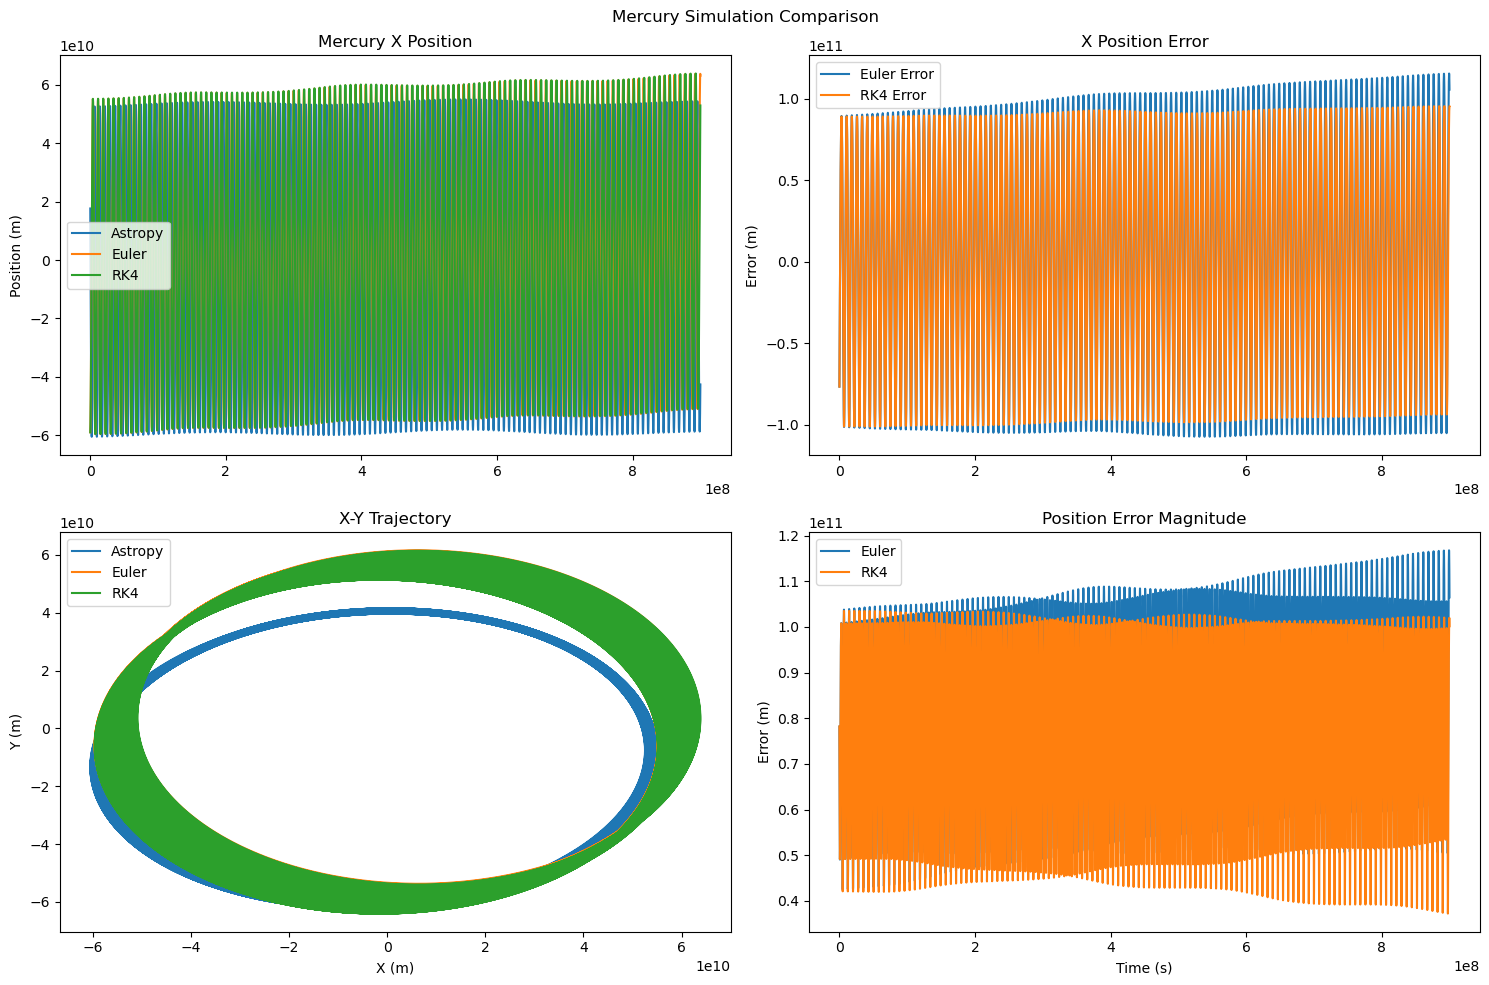

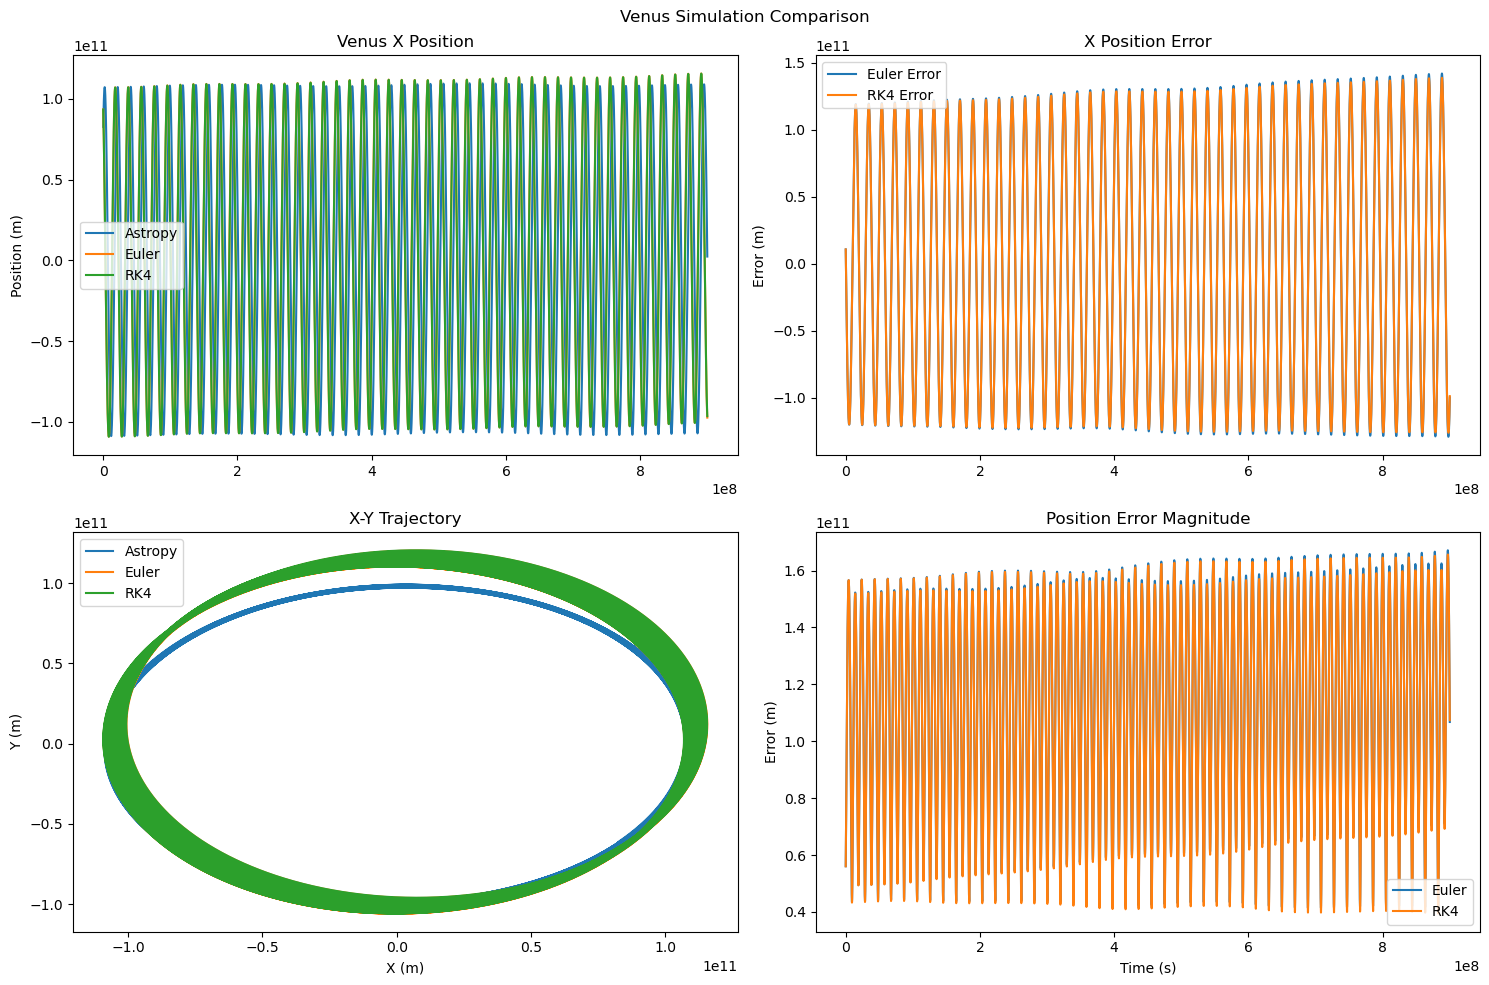

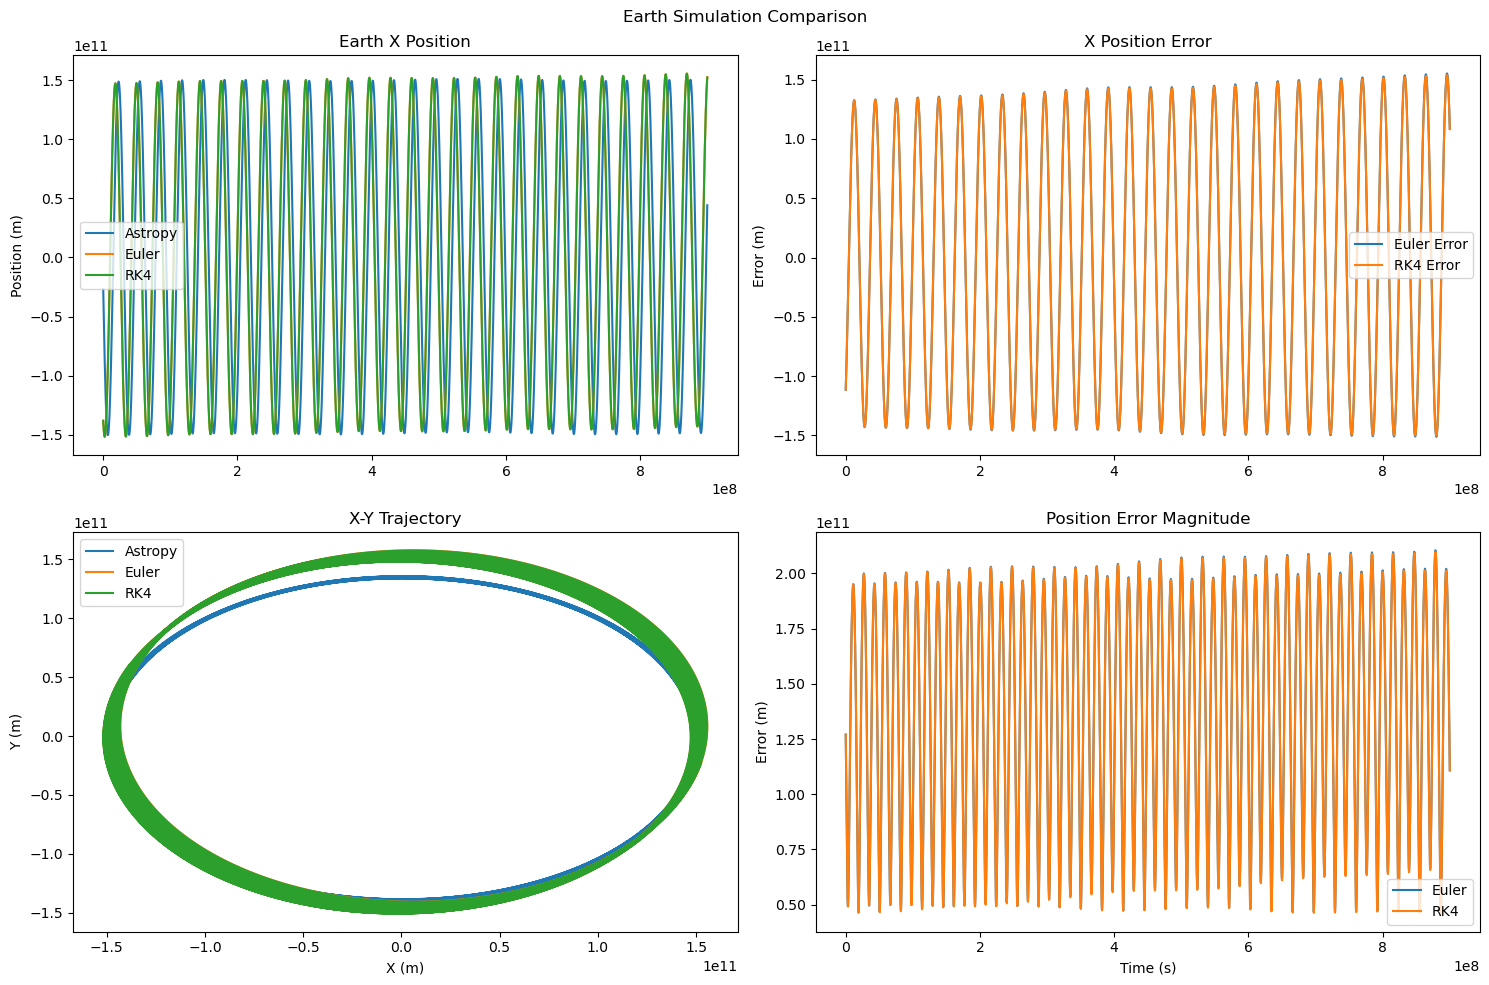

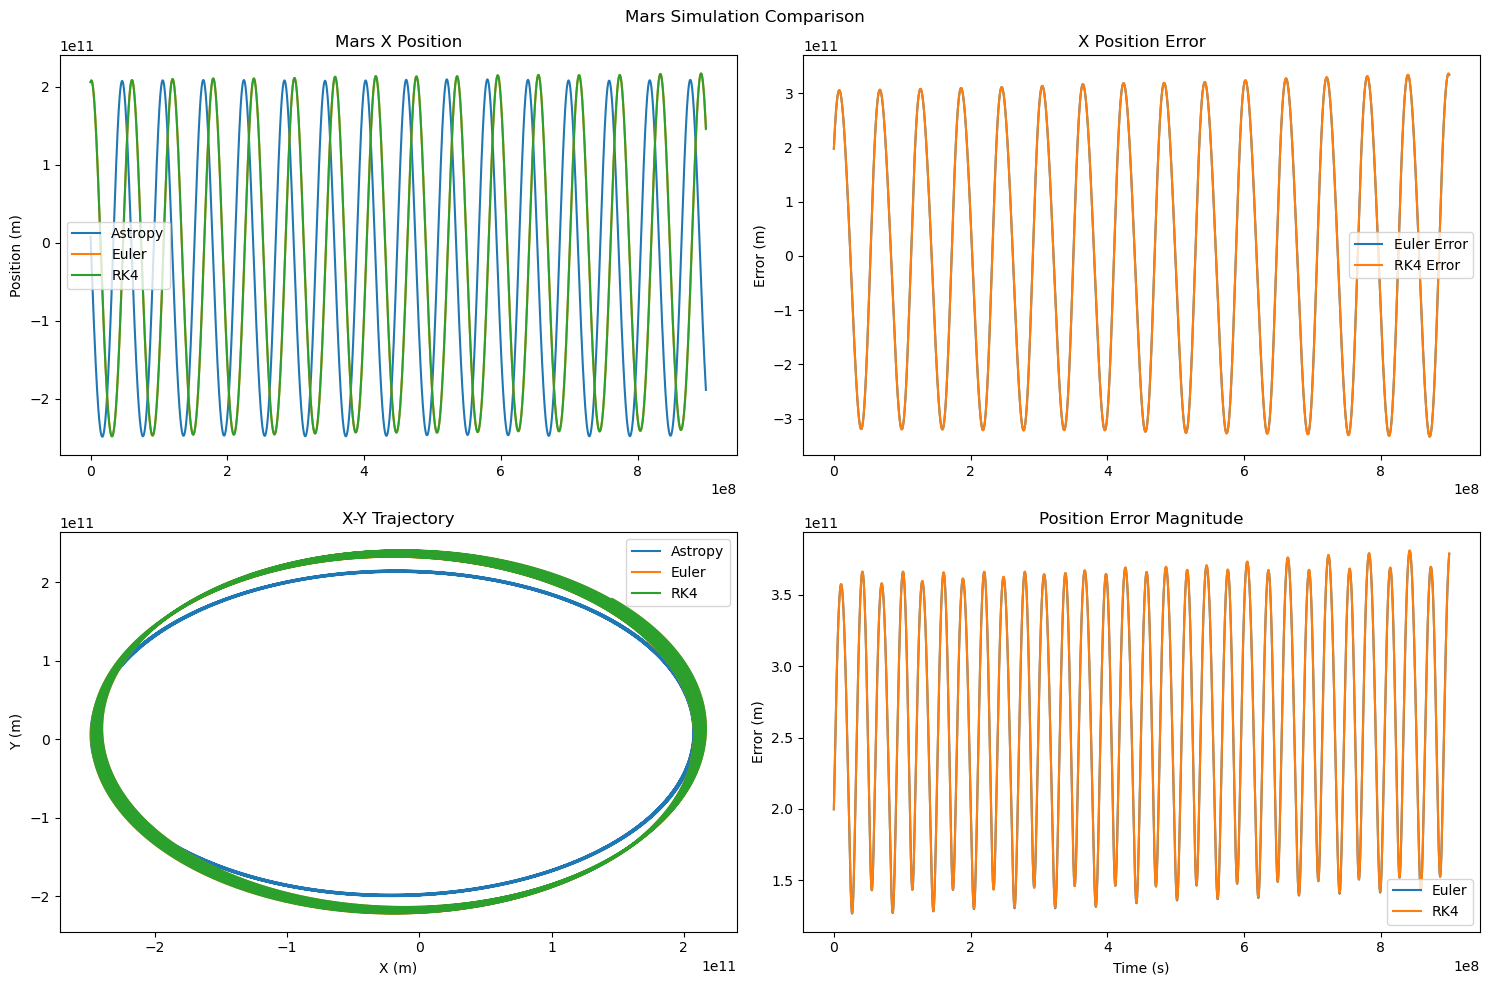

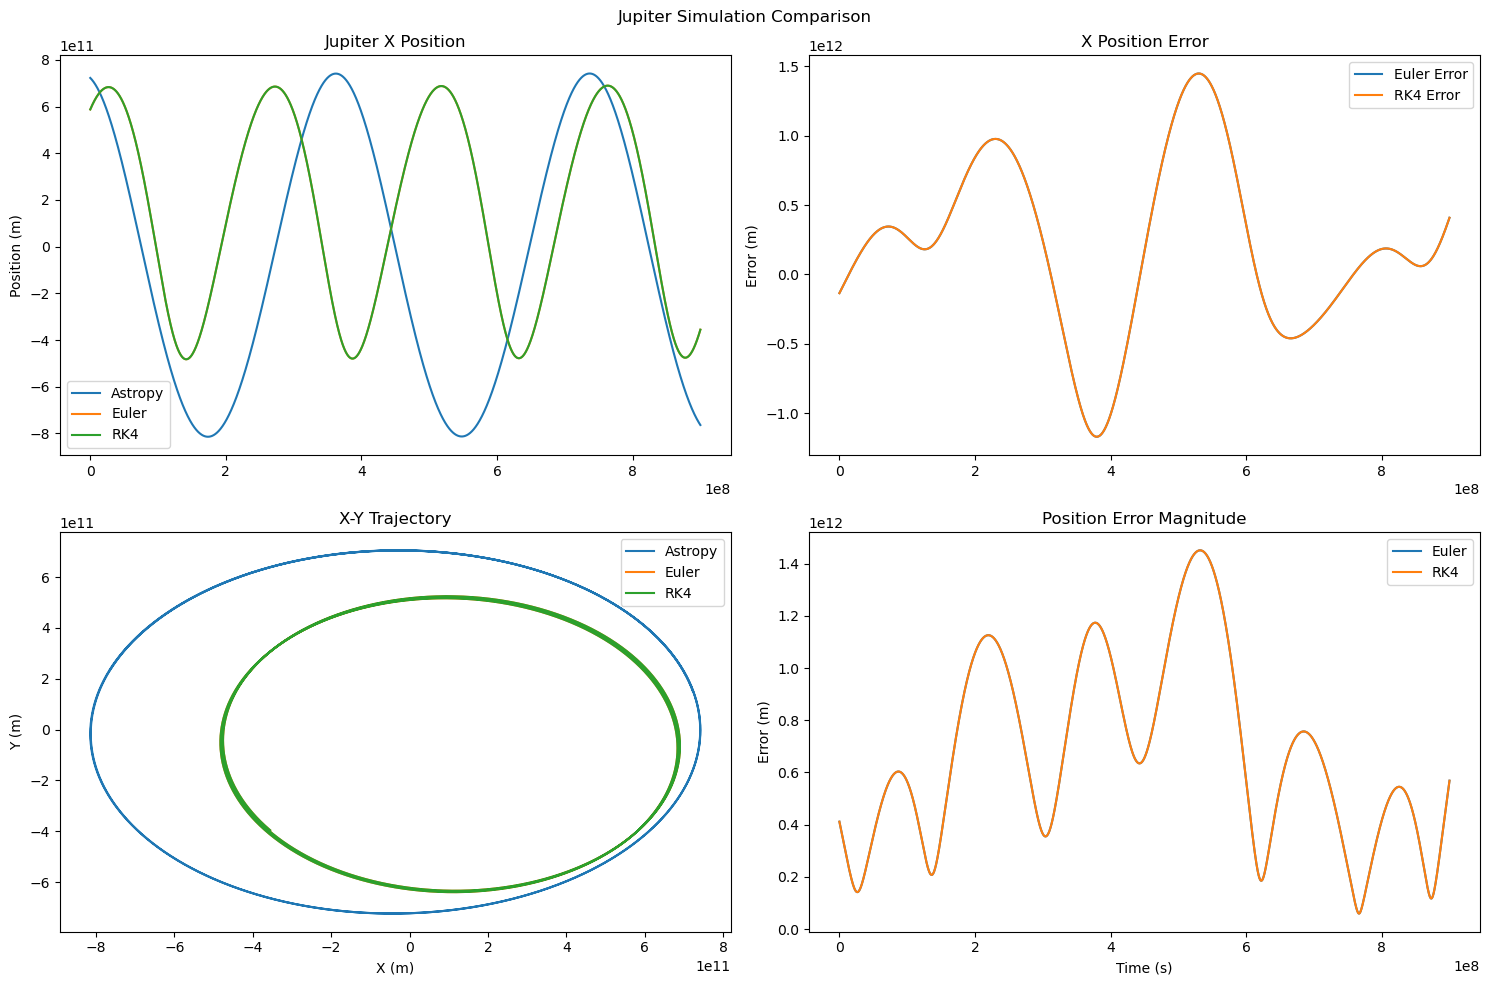

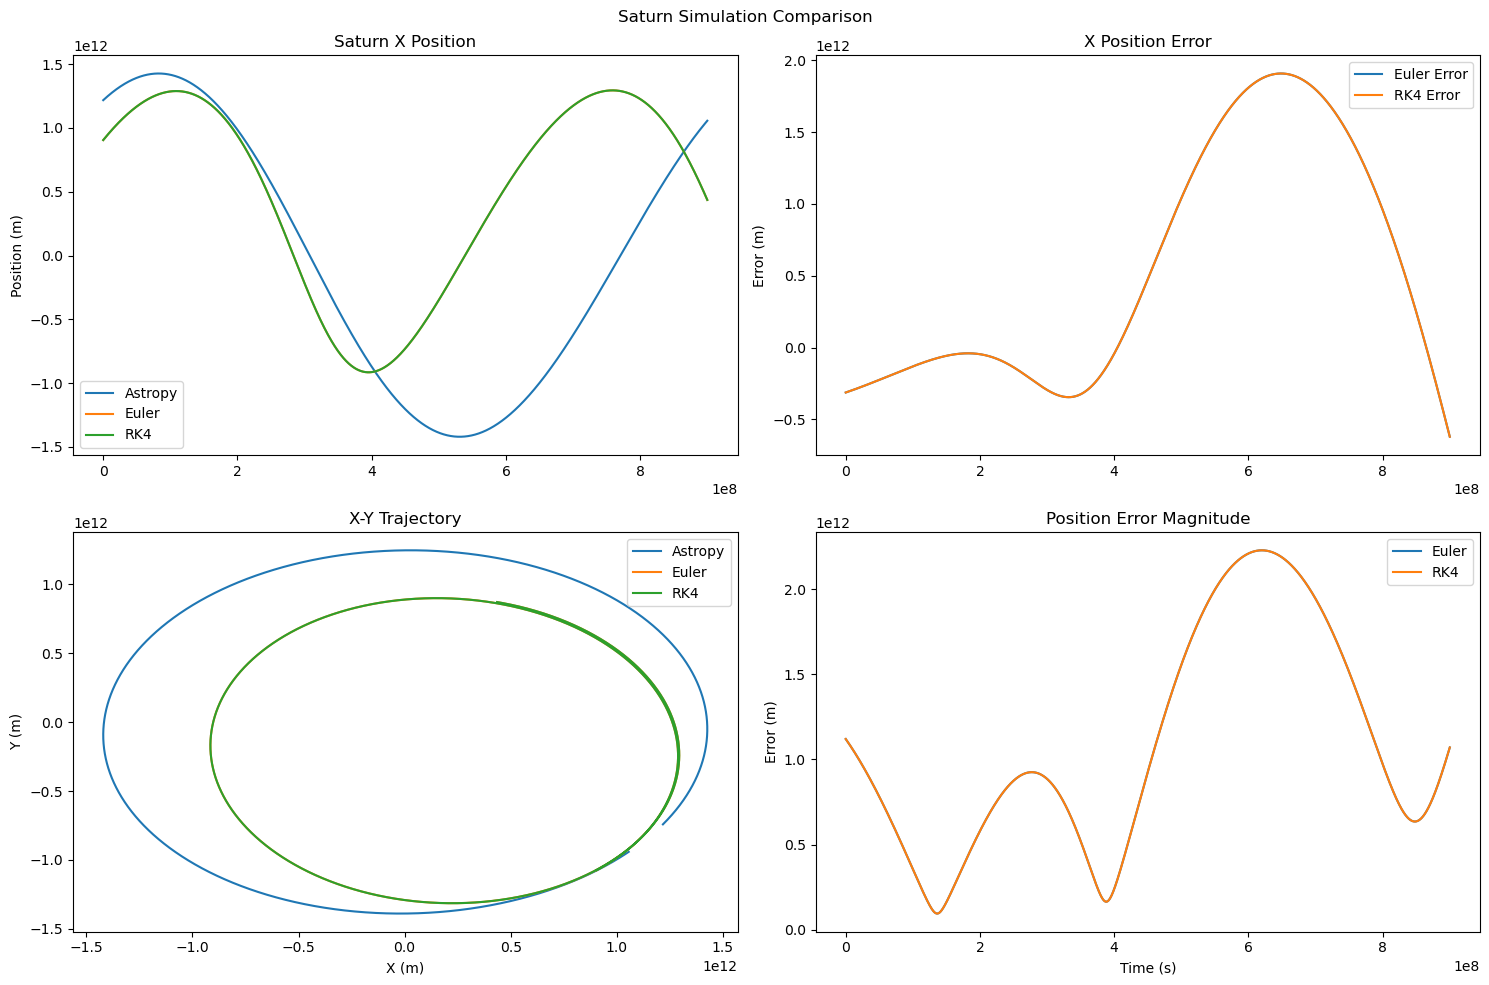

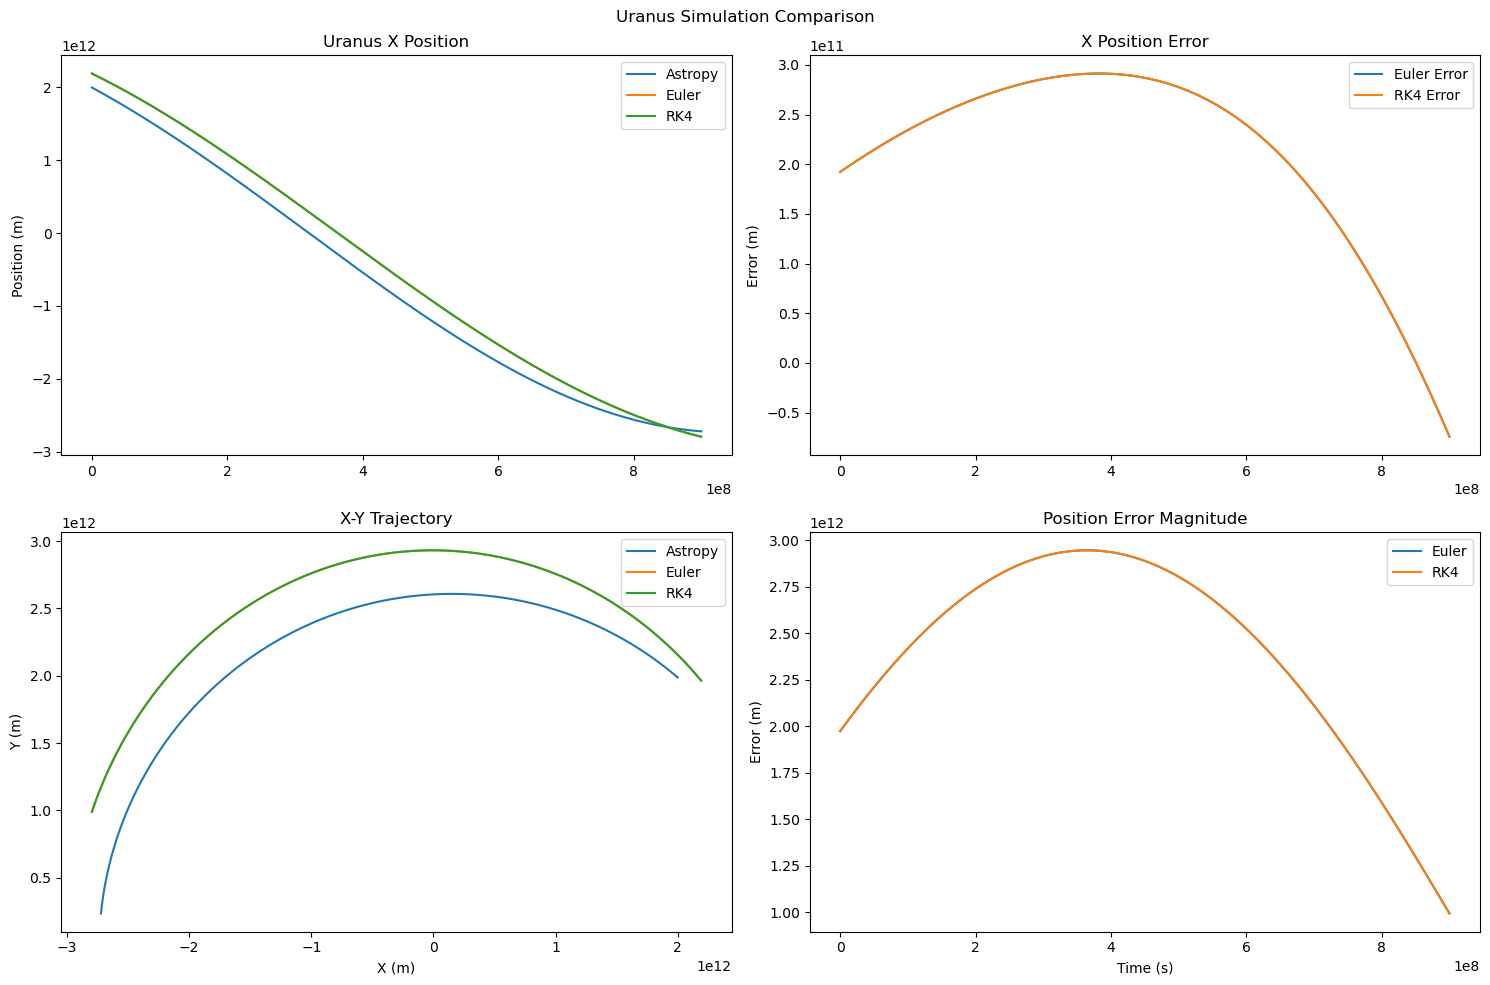

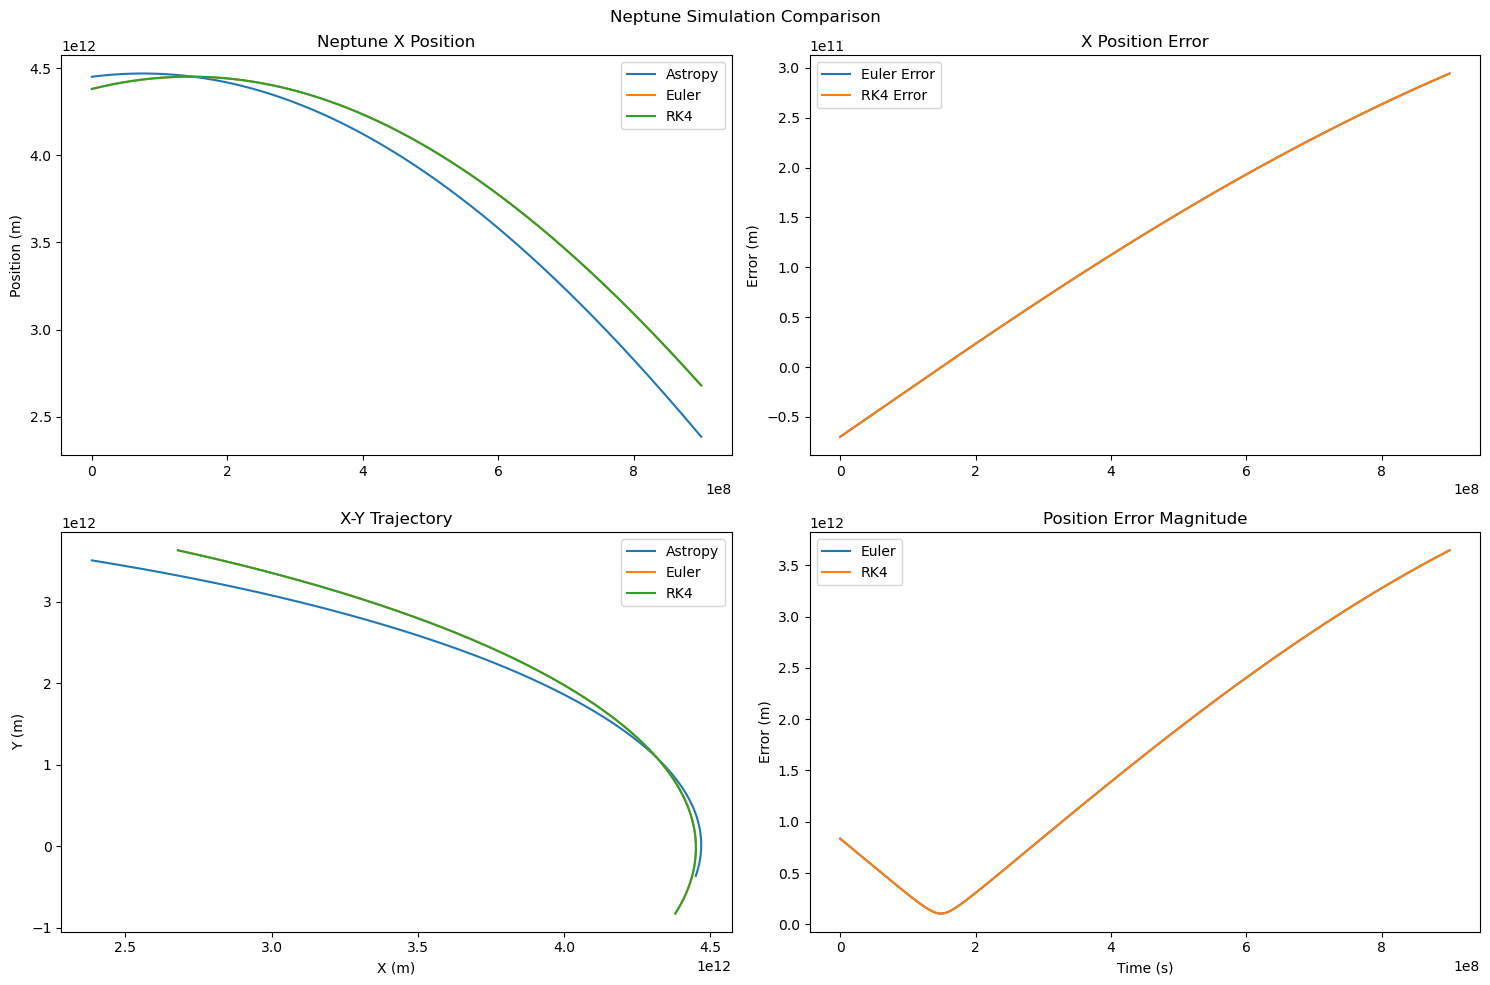


Error Statistics:

Mercury:
Euler - Mean Error: 1.04e+11 m, Max Error: 1.29e+11 m
RK4   - Mean Error: 9.52e+10 m, Max Error: 1.13e+11 m

Venus:
Euler - Mean Error: 1.28e+11 m, Max Error: 1.51e+11 m
RK4   - Mean Error: 1.27e+11 m, Max Error: 1.48e+11 m

Earth:
Euler - Mean Error: 1.49e+11 m, Max Error: 1.66e+11 m
RK4   - Mean Error: 1.48e+11 m, Max Error: 1.65e+11 m

Mars:
Euler - Mean Error: 3.20e+11 m, Max Error: 3.46e+11 m
RK4   - Mean Error: 3.21e+11 m, Max Error: 3.46e+11 m

Jupiter:
Euler - Mean Error: 8.34e+11 m, Max Error: 1.48e+12 m
RK4   - Mean Error: 8.34e+11 m, Max Error: 1.48e+12 m

Saturn:
Euler - Mean Error: 1.28e+12 m, Max Error: 1.96e+12 m
RK4   - Mean Error: 1.28e+12 m, Max Error: 1.96e+12 m

Uranus:
Euler - Mean Error: 1.05e+12 m, Max Error: 1.22e+12 m
RK4   - Mean Error: 1.05e+12 m, Max Error: 1.22e+12 m

Neptune:
Euler - Mean Error: 8.69e+11 m, Max Error: 1.55e+12 m
RK4   - Mean Error: 8.69e+11 m, Max Error: 1.55e+12 m


In [46]:
# =====================================================================
# IMPORT LIBRARIES
# =====================================================================
from vpython import *          # For 3D visualization
import pandas as pd            # For data handling and analysis
import numpy as np             # For numerical operations
from datetime import datetime, timedelta  # For time handling
import matplotlib.pyplot as plt  # For plotting results
from astropy.time import Time  # For astronomical time calculations
from astropy.coordinates import solar_system_ephemeris, get_body_barycentric  # For planetary ephemeris
import astropy.units as u      # For unit handling in astronomy

# =====================================================================
# PHYSICAL CONSTANTS AND SIMULATION PARAMETERS
# =====================================================================
G = 6.674e-11                  # Gravitational constant (m^3 kg^-1 s^-2)
radius_scale_factor = 5e3      # Scaling factor for visualization
dt = 1e4                       # Time step (seconds)
total_simulation_time = dt * 9e4  # Total simulation duration (200 million seconds)
bodies_to_compare = ['sun', 'mercury', 'venus', 'earth', 'mars', 'jupiter', 'saturn', 'uranus', 'neptune']  # All planets

# =====================================================================
# CELESTIAL BODY CLASS DEFINITION
# =====================================================================
class CelestialBody:
    """Class to represent celestial bodies with physical properties"""
    def __init__(self, name, color, pos, radius, mass, v):
        self.name = name       # Body name (e.g., "Earth")
        self.color = color     # Visualization color
        self.pos = pos         # Position vector (x,y,z) in meters
        self.radius = radius   # Physical radius in meters
        self.mass = mass       # Mass in kg
        self.v = v             # Velocity vector (vx,vy,vz) in m/s
        self.F = vector(0, 0, 0)  # Force vector (initially zero)
        self.p = self.v * self.mass  # Momentum vector (p = mv)

# =====================================================================
# INITIAL CONDITIONS FOR SOLAR SYSTEM BODIES (ALL PLANETS)
# =====================================================================
initial_bodies = [
    # Sun (central body)
    CelestialBody("Sun", color.yellow, vector(0,0,0), 
                 6.96342e8, 1.9884e30, vector(0,0,0)),
    
    # Mercury
    CelestialBody("Mercury", color.white, vector(-5.89406e10, -1.453e10, -6.1304e9), 
                 2.4397e6, 3.3011e23, vector(6591.68, -44823.7, -2404.34)),
    
    # Venus
    CelestialBody("Venus", color.orange, vector(9.33511e10, 5.48211e10, 4.42522e9), 
                 6.051e6, 4.5675e24, vector(-16959.9, 30567.2, 882.861)),
    
    # Earth
    CelestialBody("Earth", color.blue, vector(-1.38235e11, 6.09568e10, 0), 
                 6.378e6, 5.9735e24, vector(-12262.7, -26812.9, 0)),
    
    # Mars
    CelestialBody("Mars", color.red, vector(2.0567e11, -2.61614e10, 3.64974e9), 
                 1.794e6, 6.4171e24, vector(3621.45, 26168.2, 452.759)),
    
    # Jupiter
    CelestialBody("Jupiter", color.orange, vector(5.876e11, -3.885e11, -1.541e10),
                 6.9911e7, 1.89813e27, vector(6831.3, 10210.0, -191.5)),
    
    # Saturn
    CelestialBody("Saturn", color.yellow, vector(9.048e11, -1.075e12, -2.292e10),
                 5.8232e7, 5.6834e26, vector(6475.1, 5389.5, -397.3)),
    
    # Uranus
    CelestialBody("Uranus", color.cyan, vector(2.191e12, 1.964e12, -2.499e10),
                 2.5362e7, 8.6813e25, vector(-4574.3, 4991.7, 71.3)),
    
    # Neptune
    CelestialBody("Neptune", color.blue, vector(4.381e12, -8.28e11, -8.704e10),
                 2.4622e7, 1.0241e26, vector(966.8, 5495.1, -131.6))
]

# =====================================================================
# FORCE CALCULATION FUNCTION (COMMON TO BOTH METHODS)
# =====================================================================
def calculate_forces(bodies):
    """Calculate gravitational forces between all bodies"""
    for i in bodies:
        i.F = vector(0, 0, 0)  # Reset force vector
        
        # Calculate force from all other bodies
        for j in bodies:
            if i != j:  # Skip self-interaction
                r = i.pos - j.pos  # Distance vector
                if mag(r) > i.radius + j.radius:  # Only if not colliding
                    # Newton's law of gravitation:
                    F = -G * i.mass * j.mass * r.hat / mag(r)**2
                    i.F += F  # Accumulate forces

# =====================================================================
# EULER METHOD IMPLEMENTATION
# =====================================================================
def run_euler_simulation():
    """Run simulation using Euler integration method"""
    # Set up visualization
    scene_euler = canvas(title="Euler's Method Simulation", width=1000, height=600, range=5e12)
    
    # Initialize bodies with visual elements
    bodies_euler = []
    for body in initial_bodies:
        # Create visual sphere with properties
        s = sphere(pos=body.pos, color=body.color, make_trail=True, 
                  trail_type="curve", trail_color=body.color,
                  radius=body.radius)
        # Copy physical properties
        s.mass = body.mass
        s.v = body.v
        s.F = vector(0,0,0)
        s.p = s.v * s.mass
        s.label = label(pos=s.pos, text=f'{body.name}', height=10, border=4)
        bodies_euler.append(s)
    
    # Initialize data collection
    data_euler = {'time': []}
    for body in bodies_euler:
        prefix = body.label.text.lower()
        data_euler[f'{prefix}_x'] = []
        data_euler[f'{prefix}_y'] = []
        data_euler[f'{prefix}_z'] = []
    
    # Simulation loop
    current_time = 0
    while current_time <= total_simulation_time and len(bodies_euler) > 1:
        rate(100)  # Control visualization speed
        
        # Record current state
        data_euler['time'].append(current_time)
        for body in bodies_euler:
            prefix = body.label.text.lower()
            data_euler[f'{prefix}_x'].append(body.pos.x)
            data_euler[f'{prefix}_y'].append(body.pos.y)
            data_euler[f'{prefix}_z'].append(body.pos.z)
        
        # Euler integration steps:
        # 1. Calculate forces
        calculate_forces(bodies_euler)
        
        # 2. Update momentum (p = p + F*dt)
        for body in bodies_euler:
            body.p += body.F * dt
        
        # 3. Update velocity (v = p/m)
        # 4. Update position (x = x + v*dt)
        for body in bodies_euler:
            body.v = body.p / body.mass
            body.pos += body.v * dt
            body.label.pos = body.pos  # Update label position
        
        current_time += dt
    
    return pd.DataFrame(data_euler)

# =====================================================================
# RUNGE-KUTTA 4TH ORDER (RK4) IMPLEMENTATION
# =====================================================================
def derivatives(bodies):
    """Calculate derivatives for RK4 method (dx/dt = v, dv/dt = F/m)"""
    calculate_forces(bodies)  # Update all forces first
    derivs = []
    for body in bodies:
        derivs.append({
            'v': body.F/body.mass,  # dv/dt = acceleration
            'x': body.v             # dx/dt = velocity
        })
    return derivs

def run_rk4_simulation():
    """Run simulation using RK4 integration method"""
    scene_rk4 = canvas(title="RK4 Method Simulation", width=1000, height=600, range=5e12)
    
    # Initialize bodies with 
    bodies_rk4 = []
    for body in initial_bodies:
        s = sphere(pos=body.pos, color=body.color, make_trail=True,
                  trail_type="curve", trail_color=body.color,
                  radius=body.radius)
        s.mass = body.mass
        s.v = body.v
        s.F = vector(0,0,0)
        s.p = s.v * s.mass
        s.label = label(pos=s.pos, text=f'{body.name}', height=10, border=4)
        bodies_rk4.append(s)
    
    # Initialize data collection
    data_rk4 = {'time': []}
    for body in bodies_rk4:
        prefix = body.label.text.lower()
        data_rk4[f'{prefix}_x'] = []
        data_rk4[f'{prefix}_y'] = []
        data_rk4[f'{prefix}_z'] = []
    
    current_time = 0
    while current_time <= total_simulation_time and len(bodies_rk4) > 1:
        rate(100)
        
        # Record current state
        data_rk4['time'].append(current_time)
        for body in bodies_rk4:
            prefix = body.label.text.lower()
            data_rk4[f'{prefix}_x'].append(body.pos.x)
            data_rk4[f'{prefix}_y'].append(body.pos.y)
            data_rk4[f'{prefix}_z'].append(body.pos.z)
        
        # RK4 integration steps:
        # 1. Save original state
        original_state = [{
            'pos': vector(body.pos.x, body.pos.y, body.pos.z), 
            'v': vector(body.v.x, body.v.y, body.v.z)
        } for body in bodies_rk4]
        
        # 2. Calculate k1 coefficients
        k1 = derivatives(bodies_rk4)
        for i, body in enumerate(bodies_rk4):
            body.pos = original_state[i]['pos'] + 0.5*dt*k1[i]['x']
            body.v = original_state[i]['v'] + 0.5*dt*k1[i]['v']
        
        # 3. Calculate k2 coefficients
        k2 = derivatives(bodies_rk4)
        for i, body in enumerate(bodies_rk4):
            body.pos = original_state[i]['pos'] + 0.5*dt*k2[i]['x']
            body.v = original_state[i]['v'] + 0.5*dt*k2[i]['v']
        
        # 4. Calculate k3 coefficients
        k3 = derivatives(bodies_rk4)
        for i, body in enumerate(bodies_rk4):
            body.pos = original_state[i]['pos'] + dt*k3[i]['x']
            body.v = original_state[i]['v'] + dt*k3[i]['v']
        
        # 5. Calculate k4 coefficients
        k4 = derivatives(bodies_rk4)
        
        # 6. Final update using weighted average
        for i, body in enumerate(bodies_rk4):
            body.pos = original_state[i]['pos'] + (dt/6)*(
                k1[i]['x'] + 2*k2[i]['x'] + 2*k3[i]['x'] + k4[i]['x'])
            body.v = original_state[i]['v'] + (dt/6)*(
                k1[i]['v'] + 2*k2[i]['v'] + 2*k3[i]['v'] + k4[i]['v'])
            body.p = body.v * body.mass
            body.label.pos = body.pos
        
        current_time += dt
    
    return pd.DataFrame(data_rk4)

# =====================================================================
# ASTROPY REFERENCE DATA ACQUISITION
# =====================================================================
def get_astropy_data(sim_times):
    """Get reference positions from JPL ephemeris"""
    astropy_data = {'time': [], 'body': [], 'x': [], 'y': [], 'z': []}
    start_time = datetime(2023, 1, 1)  # Arbitrary reference date
    
    with solar_system_ephemeris.set('jpl'):  # Use high-precision JPL ephemeris
        for t_sec in sim_times:
            # Convert simulation time to astronomical time
            t = Time(start_time + timedelta(seconds=t_sec))
            
            # Get positions for each body
            for body in bodies_to_compare:
                pos = get_body_barycentric(body, t)  # Get barycentric position
                astropy_data['time'].append(t_sec)
                astropy_data['body'].append(body)
                astropy_data['x'].append(pos.x.to(u.m).value)  # Convert to meters
                astropy_data['y'].append(pos.y.to(u.m).value)
                astropy_data['z'].append(pos.z.to(u.m).value)
    
    return pd.DataFrame(astropy_data)

# =====================================================================
# COMPARISON AND VISUALIZATION FUNCTIONS (PART 4)
# =====================================================================
def compare_methods(euler_df, rk4_df, astropy_df):
    """Compare simulation results and generate plots"""
    results = {}
    
    for body in bodies_to_compare:
        # Skip the sun for plotting (its position is fixed at origin)
        if body == 'sun':
            continue
            
        # Prepare data from each method
        euler_data = euler_df[['time', f'{body}_x', f'{body}_y', f'{body}_z']].copy()
        euler_data.columns = ['time', 'x', 'y', 'z']
        euler_data['method'] = 'Euler'
        
        rk4_data = rk4_df[['time', f'{body}_x', f'{body}_y', f'{body}_z']].copy()
        rk4_data.columns = ['time', 'x', 'y', 'z']
        rk4_data['method'] = 'RK4'
        
        astro_data = astropy_df[astropy_df['body'] == body][['time', 'x', 'y', 'z']].copy()
        astro_data['method'] = 'Astropy'
        
        # Combine all data for this body
        combined = pd.concat([euler_data, rk4_data, astro_data])
        results[body] = combined
        
        # Create comparison plots
        plt.figure(figsize=(15, 10))
        
        # Plot 1: X Position vs Time
        plt.subplot(2, 2, 1)
        for method, df in combined.groupby('method'):
            plt.plot(df['time'], df['x'], label=method)
        plt.title(f'{body.capitalize()} X Position')
        plt.ylabel('Position (m)')
        plt.legend()
        
        # Plot 2: X Position Error vs Time
        plt.subplot(2, 2, 2)
        euler_err = euler_data.copy()
        euler_err['x'] -= astro_data['x'].values
        rk4_err = rk4_data.copy()
        rk4_err['x'] -= astro_data['x'].values
        plt.plot(euler_err['time'], euler_err['x'], label='Euler Error')
        plt.plot(rk4_err['time'], rk4_err['x'], label='RK4 Error')
        plt.title('X Position Error')
        plt.ylabel('Error (m)')
        plt.legend()
        
        # Plot 3: X-Y Trajectory
        plt.subplot(2, 2, 3)
        for method, df in combined.groupby('method'):
            plt.plot(df['x'], df['y'], label=method)
        plt.title('X-Y Trajectory')
        plt.xlabel('X (m)')
        plt.ylabel('Y (m)')
        plt.legend()
        
        # Plot 4: Error Magnitude vs Time
        plt.subplot(2, 2, 4)
        euler_err['error_mag'] = np.sqrt(euler_err['x']**2 + euler_err['y']**2 + euler_err['z']**2)
        rk4_err['error_mag'] = np.sqrt(rk4_err['x']**2 + rk4_err['y']**2 + rk4_err['z']**2)
        plt.plot(euler_err['time'], euler_err['error_mag'], label='Euler')
        plt.plot(rk4_err['time'], rk4_err['error_mag'], label='RK4')
        plt.title('Position Error Magnitude')
        plt.xlabel('Time (s)')
        plt.ylabel('Error (m)')
        plt.legend()
        
        plt.suptitle(f'{body.capitalize()} Simulation Comparison')
        plt.tight_layout()
        plt.show()
    
    return results

# =====================================================================
# MAIN EXECUTION
# =====================================================================
if __name__ == "__main__":
    print("Running Euler simulation...")
    euler_results = run_euler_simulation()

    print("\nRunning RK4 simulation...")
    rk4_results = run_rk4_simulation()

    print("\nGetting Astropy reference data...")
    astropy_data = get_astropy_data(euler_results['time'].unique())

    print("\nComparing methods...")
    comparison_results = compare_methods(euler_results, rk4_results, astropy_data)

    # Calculate and display error statistics
    print("\nError Statistics:")
    for body in bodies_to_compare:
        if body == 'sun':  # Skip sun as it's fixed
            continue
            
        # Calculate error magnitudes
        euler_err = comparison_results[body][comparison_results[body]['method'] == 'Euler']
        rk4_err = comparison_results[body][comparison_results[body]['method'] == 'RK4']
        
        # Euclidean distance between simulation and Astropy
        euler_error_mag = np.sqrt(
            (euler_err['x'] - astropy_data[astropy_data['body'] == body]['x'].values)**2 +
            (euler_err['y'] - astropy_data[astropy_data['body'] == body]['y'].values)**2 +
            (euler_err['z'] - astropy_data[astropy_data['body'] == body]['z'].values)**2)
        
        rk4_error_mag = np.sqrt(
            (rk4_err['x'] - astropy_data[astropy_data['body'] == body]['x'].values)**2 +
            (rk4_err['y'] - astropy_data[astropy_data['body'] == body]['y'].values)**2 +
            (rk4_err['z'] - astropy_data[astropy_data['body'] == body]['z'].values)**2)
        
        # Print statistics
        print(f"\n{body.capitalize()}:")
        print(f"Euler - Mean Error: {euler_error_mag.mean():.2e} m, Max Error: {euler_error_mag.max():.2e} m")
        print(f"RK4   - Mean Error: {rk4_error_mag.mean():.2e} m, Max Error: {rk4_error_mag.max():.2e} m")